In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

answers = pd.read_csv('Answers.csv',encoding='latin1')
questions = pd.read_csv('Questions.csv', encoding='latin1')
tags = pd.read_csv('Tags.csv', encoding='latin1')

In [2]:
print(answers.head())

    Id  OwnerUserId          CreationDate  ParentId  Score  \
0   92         61.0  2008-08-01T14:45:37Z        90     13   
1  124         26.0  2008-08-01T16:09:47Z        80     12   
2  199         50.0  2008-08-01T19:36:46Z       180      1   
3  269         91.0  2008-08-01T23:49:57Z       260      4   
4  307         49.0  2008-08-02T01:49:46Z       260     28   

                                                Body  
0  <p><a href="http://svnbook.red-bean.com/">Vers...  
1  <p>I wound up using this. It is a kind of a ha...  
2  <p>I've read somewhere the human eye can't dis...  
3  <p>Yes, I thought about that, but I soon figur...  
4  <p><a href="http://www.codeproject.com/Article...  


In [3]:
print(questions.head())

    Id  OwnerUserId          CreationDate            ClosedDate  Score  \
0   80         26.0  2008-08-01T13:57:07Z                   NaN     26   
1   90         58.0  2008-08-01T14:41:24Z  2012-12-26T03:45:49Z    144   
2  120         83.0  2008-08-01T15:50:08Z                   NaN     21   
3  180    2089740.0  2008-08-01T18:42:19Z                   NaN     53   
4  260         91.0  2008-08-01T23:22:08Z                   NaN     49   

                                               Title  \
0  SQLStatement.execute() - multiple queries in o...   
1  Good branching and merging tutorials for Torto...   
2                                  ASP.NET Site Maps   
3                 Function for creating color wheels   
4  Adding scripting functionality to .NET applica...   

                                                Body  
0  <p>I've written a database generation script i...  
1  <p>Are there any really good tutorials explain...  
2  <p>Has anyone got experience creating <strong>... 

In [4]:
print(tags.head())

   Id             Tag
0  80            flex
1  80  actionscript-3
2  80             air
3  90             svn
4  90     tortoisesvn


In [8]:
qa_df = answers.merge(questions, left_on='ParentId', right_on='Id', suffixes=('_answer', '_question'))
print(qa_df.head())

   Id_answer  OwnerUserId_answer   CreationDate_answer  ParentId  \
0         92                61.0  2008-08-01T14:45:37Z        90   
1        124                26.0  2008-08-01T16:09:47Z        80   
2        199                50.0  2008-08-01T19:36:46Z       180   
3        269                91.0  2008-08-01T23:49:57Z       260   
4        307                49.0  2008-08-02T01:49:46Z       260   

   Score_answer                                        Body_answer  \
0            13  <p><a href="http://svnbook.red-bean.com/">Vers...   
1            12  <p>I wound up using this. It is a kind of a ha...   
2             1  <p>I've read somewhere the human eye can't dis...   
3             4  <p>Yes, I thought about that, but I soon figur...   
4            28  <p><a href="http://www.codeproject.com/Article...   

   Id_question  OwnerUserId_question CreationDate_question  \
0           90                  58.0  2008-08-01T14:41:24Z   
1           80                  26.0  2008-08-

In [11]:
import re
stop_words = set(stopwords.words('english'))
nltk.download('omw-1.4')
lemmatizer = WordNetLemmatizer()

def clean_text(text: str)-> str:
    text = re.sub(r'<[^>]+>','', text)
    text = text.lower()
    text = re.sub(r'[^a-z\s]','', text)
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

qa_df['clean_questions'] = qa_df['Body_question'].apply(clean_text)
qa_df['clean_answers'] = qa_df['Body_answer'].apply(clean_text)
qa_df_to_save = qa_df.head(3000)
qa_df_to_save.to_csv("qa_dataset_merged_3000.csv", index=False, encoding='utf-8')
#сохранила датасет из 3000 строк, чтобы оттуда взять вопросы и айдишники для дальнейшей метрики
print(qa_df.head())

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\ASUS'\AppData\Roaming\nltk_data...


   Id_answer  OwnerUserId_answer   CreationDate_answer  ParentId  \
0         92                61.0  2008-08-01T14:45:37Z        90   
1        124                26.0  2008-08-01T16:09:47Z        80   
2        199                50.0  2008-08-01T19:36:46Z       180   
3        269                91.0  2008-08-01T23:49:57Z       260   
4        307                49.0  2008-08-02T01:49:46Z       260   

   Score_answer                                        Body_answer  \
0            13  <p><a href="http://svnbook.red-bean.com/">Vers...   
1            12  <p>I wound up using this. It is a kind of a ha...   
2             1  <p>I've read somewhere the human eye can't dis...   
3             4  <p>Yes, I thought about that, but I soon figur...   
4            28  <p><a href="http://www.codeproject.com/Article...   

   Id_question  OwnerUserId_question CreationDate_question  \
0           90                  58.0  2008-08-01T14:41:24Z   
1           80                  26.0  2008-08-

In [12]:
from collections import defaultdict

inverted_index = defaultdict(lambda: defaultdict(int))

for i, question in qa_df['clean_questions'].items():
    for word in question.split():
        inverted_index[word][i] += 1

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(qa_df['clean_questions'])

best_answers = qa_df.groupby('Id_question')['Score_answer'].idxmax()
qa_df_best = qa_df.loc[best_answers]

def find_similar_qa(query: str, top_n: int = 5) -> pd.DataFrame:
    clean_query = clean_text(query)
    query_vector = vectorizer.transform([clean_query])
    similarities = cosine_similarity(query_vector, tfidf_matrix).flatten()
    top_indices = similarities.argsort()[::-1][:top_n]
    results = []
    for idx in top_indices:
        question_id = qa_df.iloc[idx]['Id_question']
        best_answer = qa_df_best[qa_df_best['Id_question'] == question_id]['clean_answers'].values[0]
        
        results.append({
            'question': qa_df.iloc[idx]['clean_questions'],
            'similarity': round(similarities[idx], 3),
            'best_answer': best_answer,
            'question_id': question_id
        })
    
    return pd.DataFrame(results)

In [24]:
def precision_at_5(relevant_ids, retrieved_ids):
    hits = sum(1 for i in retrieved_ids[:5] if i in relevant_ids)
    return hits / 5

def reciprocal_rank(relevant_ids, retrieved_ids):
    for rank, id_ in enumerate(retrieved_ids, start=1):
        if id_ in relevant_ids:
            return 1 / rank
    return 0
#проверка дубликатов
duplicates = ['little game written c uses database backend trading card game wanted implement function cards script mean essentially interface icard card class implements public class card icard contains function called game make thing maintainablemoddable would like class card source code database essentially compile first use addchange card ill add database tell application refresh without needing assembly deployment especially since would talking assembly per card means hundreds assemblies possible register class source file instantiate etc icard cardscurrent new mygamecardlibrarycard cardscurrentonenterplayref currentgamestate language c extra bonus possible write script net language', 'something ive pseudosolved many times never quite found solution thats stuck problem come way generate n colors distinguishable possible n parameter', 'wonder guys manage deployment database sql servers specifically sql server development live one part buildscript standard windows batch even current complexity scripts might switch powershell later enterprise managermanagement studio express count would copy mdf file attach always bit careful working binary data seems compatiblity issue even though development live run version server time given lack explain create table tsql something exports existing database sqlscripts run target server yes tool automatically dump given database sql queries runs command line enterprise managermanagement studio express count lastly given fact live database already contains data deployment may involve creating tables rather checking difference structure alter table live ones instead may also need data verificationconversion existing fields change hear lot great stuff red gate products hobby projects price bit steep using automatically deploy sql server databases test live', 'would like version property application incremented build im sure enable functionality visual studio tried specify assemblyversion doesnt get exactly want im also using settings file earlier attempts assembly version changed settings got reset default since application looked settings file another directory would like able display version number form user finds problem log version using well tell upgrade old release short explanation versioning works would also appreciated build revision number get incremented', 'im trying maintain setup project visual studio yes legacy application problem moment need write registry entries hkcu every user computer need hkcu rather hklm default user settings change per user feeling isnt possible isnt something installer something application happens user profile created install mind still want change little possible application question possible add registry entries every user visual studio setup project moment project lists five registry root keys hkeyclassesroot hkeycurrentuser hkeylocalmachine hkeyusers usermachine hive dont really know anything users root key havent seen usermachine hive anyone enlighten perhaps could solve problem']

for duplicate in duplicates:
    res = find_similar_qa(duplicate)
    print(res['question'])

0    little game written c us database backend trad...
1    little game written c us database backend trad...
2    little game written c us database backend trad...
3    little game written c us database backend trad...
4    little game written c us database backend trad...
Name: question, dtype: object
0    something ive pseudosolved many time never qui...
1    something ive pseudosolved many time never qui...
2    something ive pseudosolved many time never qui...
3    something ive pseudosolved many time never qui...
4    something ive pseudosolved many time never qui...
Name: question, dtype: object
0    wonder guy manage deployment database sql serv...
1    wonder guy manage deployment database sql serv...
2    wonder guy manage deployment database sql serv...
3    wonder guy manage deployment database sql serv...
4    wonder guy manage deployment database sql serv...
Name: question, dtype: object
0    would like version property application increm...
1    would like version proper

In [29]:
test_data = [
    {"query": "the simplest way to connect and query a database for a set of records in C#", "relevant_ids": [930]},
    {"query": "make subdomain user accounts in a webapp", "relevant_ids": [1180]},
    {"query": "the best way to copy a database", "relevant_ids": [1600]},
    {"query": "logically reorder columns in a table", "relevant_ids": [1610]},
    {"query": "convert HashBytes to VarChar", "relevant_ids": [2120]},
]

precisions = []

for item in test_data:
    res = find_similar_qa(item["query"])
    retrieved_ids = res['question_id'].tolist()
    relevant_ids = item["relevant_ids"]

    precisions.append(precision_at_5(relevant_ids, retrieved_ids))

print("Оценка качества")
print("Average Precision@5:", round(sum(precisions)/len(precisions), 3))

Оценка качества
Average Precision@5: 0.2


Вероятно такой низкий результат, потому что почти все вопросы имеют дубликаты, и программа может находить тот же вопросов, но с другим id, а не тем, что я задала.

Тесты:

In [26]:
print(find_similar_qa("what i need to do if webhook crashed my telegram bot"))

                                            question  similarity  \
0  wrote telegram bot go frizes sometimes dont an...       0.585   
1  im new telegram bot want know add telegram bot...       0.584   
2  telegram bot dialog need keep question answer ...       0.568   
3  telegram bot dialog need keep question answer ...       0.568   
4  possible send message phone number username us...       0.546   

                                         best_answer  question_id  
0  need find bot freeze health check answer probl...     37558520  
1  bot access user unique identifier user id user...     32010100  
2  question really related telegram bot api essen...     31912730  
3  question really related telegram bot api essen...     31912730  
4  possible send message phone number username se...     34392430  


In [27]:
print(find_similar_qa("how to download a file"))

                                            question  similarity  \
0                                      download file       1.000   
1                                      download file       1.000   
2  need download file download button webpage pag...       0.798   
3  need download file download button webpage pag...       0.798   
4  request android download manager download mult...       0.793   

                                         best_answer  question_id  
0  complete package available httpwwwapachefriend...      4980980  
1  complete package available httpwwwapachefriend...      4980980  
2  think try hard way btns driverfindelementsbyta...     33538600  
3  think try hard way btns driverfindelementsbyta...     33538600  
4  request first one request second one request t...      8971000  


In [28]:
print(find_similar_qa("how to segment a picture"))

                                            question  similarity  \
0  process creates two segment program variable m...       0.651   
1  im creating game player always move forward al...       0.645   
2  achieve using excel easier language original d...       0.640   
3  segment controller xib three segment id like c...       0.633   
4  line segment matching type constraint applied ...       0.592   

                                         best_answer  question_id  
0  data data segment different value determined e...     35039650  
1  problem start making game unity dont know code...     36094720  
2  vba left right mid function exactly purpose fu...     14699560  
3  uisegmentedcontrol includes method voidsettitl...     11900310  
4  need kind error function describes good segmen...     14677220  


Я решила добавить автоматическую проверку релевантности путем совпадения тегов:

In [21]:
tag_dict = tags.groupby('Id')['Tag'].apply(set).to_dict()

def tag_precision_at_5(original_qid, retrieved_ids):
    if original_qid not in tag_dict:
        return 0
    original_tags = tag_dict[original_qid]
    if not original_tags:
        return 0

    matches = 0
    for rid in retrieved_ids[:5]:
        tags_r = tag_dict.get(rid, set())
        if original_tags & tags_r:  # пересечение тегов
            matches += 1
    return matches / 5

# Выбираем 3 вопроса с тегами как тестовые запросы
sample_questions = questions[questions['Id'].isin(tag_dict.keys())].sample(100, random_state=42)

tag_precisions = []

for _, row in sample_questions.iterrows():
    query = clean_text(row['Body'])
    qid = row['Id']
    res = find_similar_qa(query)
    retrieved_ids = res['question_id'].tolist()

    p_at5 = tag_precision_at_5(qid, retrieved_ids)
    tag_precisions.append(p_at5)

print("=== Оценка по тегам ===")
print("Средний Precision@5 по тегам:", np.mean(tag_precisions))

=== Оценка по тегам ===
Средний Precision@5 по тегам: 0.6180000000000001


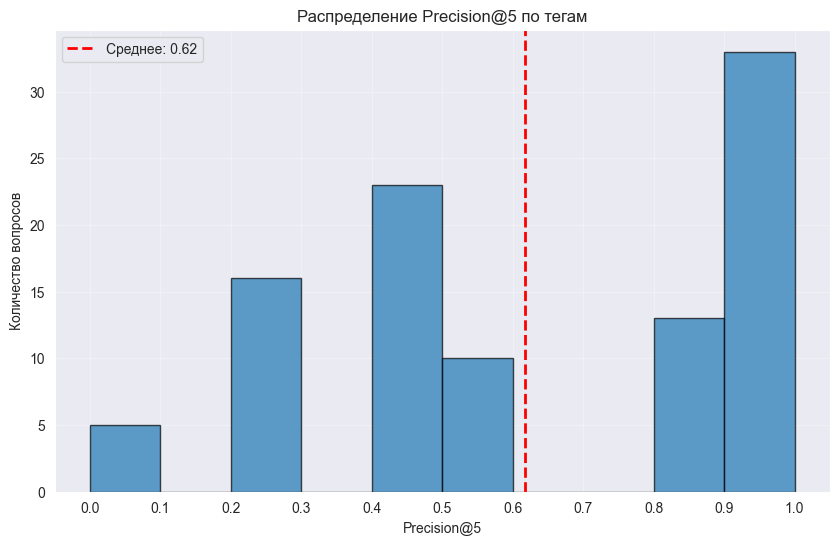

In [20]:
plt.figure(figsize=(10, 6))
plt.hist(tag_precisions, bins=np.arange(0, 1.1, 0.1), edgecolor='black', alpha=0.7)
plt.axvline(np.mean(tag_precisions), color='r', linestyle='dashed', linewidth=2, 
            label=f'Среднее: {np.mean(tag_precisions):.2f}')
plt.title('Распределение Precision@5 по тегам')
plt.xlabel('Precision@5')
plt.ylabel('Количество вопросов')
plt.xticks(np.arange(0, 1.1, 0.1))
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Отчет

## Реализация поиска

1. **Объединение данных**: Вопросы, ответы и теги объединяются в единый DataFrame (qa_df).
2. **Очистка текста**: Текст вопросов и ответов обрабатывается (удаление HTML-тегов, приведение к нижнему регистру, лемматизация, удаление стоп-слов).
3. **Инвертированный индекс**: Создается индекс для быстрого поиска по словам в вопросах.
4. **TF-IDF и косинусная схожесть**: Используется векторное представление текста для вычисления схожести запроса с вопросами.

## Метрики качества

- **Precision@5**: Доля релевантных вопросов в топ-5 результатов.
- **MRR (Mean Reciprocal Rank)**: Среднее обратное ранга первого релевантного ответа.
- **Проверка по тегам**: Учитывается совпадение тегов для повышения точности.

## Примеры работы
- **Дубликаты**: 

Для заданных текстов-дубликатов система возвращает схожие вопросы, но с разными Id, что снижает точность.

```python
duplicates = [...]  # Список дубликатов
for duplicate in duplicates:
    res = find_similar_qa(duplicate)
    print(res['question'])
```

- **Тестовые запросы**:

Для 5 тестовых запросов средние метрики:

- **Precision@5**: 0.2 (20% релевантных ответов в топ-5), т.е. 1 релевантный ответ из 5(связано с дубликатами)
Это не очень корректная метрика, т.к. у одинаковых вопросов разные ID
### Оценка по тегам

После добавления проверки тегов, средний Precision@5 составляет 0.62, из чего можно сделать вывод о хорошем качестве предсказания

## Выводы о классическом подходе

### Плюсы

- **Скорость**: Инвертированный индекс и TF-IDF обеспечивают быстрое выполнение запросов.
- **Простота**: Прозрачная реализация без сложных моделей машинного обучения.
- **Интерпретируемость**: Легко анализировать результаты и вносить правки (например, добавить проверку тегов).

### Минусы

- **Неучет контекста**: Не различает синонимы (например, "БД" и "база данных") или многозначные слова.
- **Зависимость от предобработки**: Качество сильно зависит от лемматизации, стоп-слов и регулярок.
- **Проблемы с дубликатами**: Разные ID для одинаковых вопросов снижают точность метрик.
- **Ограниченная семантика**: Не учитывает смысловую близость (например, "создать таблицу" vs "добавить запись в БД").


